# Programming Exercise 4: Neural Networks Learning

In [1]:
import numpy as np
import pandas as pd

import scipy.optimize as opt

import os
from scipy.io import loadmat

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Necessary Functions

In [2]:
def displayData(X, example_width=None):
    #Displays 2D data stored in X in a nice grid. It returns the figure handle h and the displayed array if requested
    
    plt.close()
    
    #Create a new figure
    plt.figure()
    
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    
    # Gray Image
    plt.set_cmap("gray")    
    
    #Set example_width automatically if not passed in
    if (not example_width) or not 'example_width' in locals():
        example_width = int(np.round(np.sqrt(X.shape[1])))
    
    #Gray image
    
    
    #Compute rows, cols
    m, n = X.shape
    example_height = int((n/example_width))
    
    #Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m/display_rows))
    
    #Between images padding
    pad = 1
    
    #Setup blank display
    display_array = - np.ones([pad + int(display_rows) * (int(example_height) + pad), 
                               pad + int(display_cols) * (int(example_width) + pad)])
    
    #Copy each example into a patch on the display array
    curr_ex = 1
    for j in range(1, int(display_rows)+1):
        for i in range(1, int(display_cols)+1):
            if (curr_ex > m):
                break;
            
            #Copy the patch
            
            #Get the maximum value of the patch
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (example_height, example_width), order="F") / max_val
            curr_ex = curr_ex + 1
            
        if (curr_ex > m):
            break
    
    #Display Image
    h = plt.imshow(display_array, vmin=-1, vmax=1)
    
    #Do not show axis
    plt.axis('off')
    
    plt.show(block = False)
    
    return h, display_array

In [3]:
def sigmoid(z):
    #g = SIGMOID(z) computes the sigmoid of z.
    
    from scipy.special import expit
    #Computation
    g = np.zeros(np.shape(z))
    #g = 1/(1+np.exp(-z))
    
    g = expit(z)
    
    return g

In [4]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_):
    
    #Setup up variables
    m = X.shape[0]
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], 
                        (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, hidden_layer_size + 1), order='F')
    
    #Return the following variables correctly
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    
    #Part 1: Feedforward the NN and return cost in the variable J. After completing part 1, verify that the cost computation is correct.
    I = np.eye(num_labels)
    Y = np.zeros((m, num_labels))
    for i in range(m):
        Y[i,:] = I[y[i], :]
    
    #Calculating for hidden layer a2 with parameters Theta1 and a1, where a1 contains bias unit and X
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)#a1.shape = (5000, 401) = input layer with bias unit
    a2 = sigmoid(a1.dot(Theta1.T)) #shape = (5000, 25)
    
    #Calculating the output layer a3 (h) with parameters Theta2 and a2, where a2 contains bias unit and a2
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)#a2.shape = (5000, 26) = input layer with bias unit
    a3 = sigmoid(a2.dot(Theta2.T)) #shape = (5000, 10)
    
    J = np.sum((np.sum(-Y*np.log(a3) - (1-Y)*np.log(1-a3),1)))/m
    
    #Regularization
    reg = (np.sum(np.sum((Theta1[:,1:]**2),1)) + np.sum(np.sum((Theta2[:,1:]**2),1))) * lambda_/(2*m)
    J = J+reg
    
    '''
    Part 2: Implement the backpropagation algorithm to compute the gradients
         Theta1_grad and Theta2_grad. You should return the partial derivatives of
         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
         Theta2_grad, respectively. After implementing Part 2, you can check
         that your implementation is correct by running checkNNGradients

         Note: The vector y passed into the function is a vector of labels
               containing values from 1..K. You need to map this vector into a 
               binary vector of 1's and 0's to be used with the neural network
               cost function.

         Hint: We recommend implementing backpropagation using a for-loop
               over the training examples if you are implementing it for the 
               first time.
    '''
    
    #%% BACKPROPAGATION
    delta_3 = a3-Y  #shape = (5000,10)
    a1_shape= (a1.dot(Theta1.T)).shape[0]
    delta_2 = ((delta_3.dot(Theta2))*(sigmoidGradient(np.concatenate([np.ones((a1_shape, 1)), a1.dot(Theta1.T)], axis=1))))[:,1:]  #shape = (5000,25)
    
    #((a1.T).dot(delta_2)).shape = (401,25)
    D1=(a1.T).dot(delta_2)  #shape = (401,25)
    D2=(a2.T).dot(delta_3)  #shape = (26,10)
    
    Theta1_grad = D1/m   #shape = (401,25)
    Theta2_grad = D2/m   #shape = (26,10)
    
    Theta1_grad = Theta1_grad.T + (lambda_/m)*(np.concatenate([np.zeros((Theta1.shape[0],1)), Theta1[:,1:]], axis=1)) #shape = (25,401)
    Theta2_grad = Theta2_grad.T + (lambda_/m)*(np.concatenate([np.zeros((Theta2.shape[0],1)), Theta2[:,1:]], axis=1)) #shape = (10,26)

    
    # Unroll gradients
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
    
    return J, grad

In [5]:
def sigmoidGradient(z):
    
    #Computation
    g = np.zeros(np.shape(z))
    
    g = sigmoid(z)*(1-sigmoid(z))
    
    return g

In [6]:
def randInitializeWeights(L_in, L_out):
    '''
    RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    incoming connections and L_out outgoing connections
       W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
        of a layer with L_in incoming connections and L_out outgoing connections. 
        
       Note that W should be set to a matrix of size(L_out, 1 + L_in) as the first column of W handles the "bias" terms
    '''
    
    #You need to return the following variables correctly
    W = np.zeros((L_out,1+L_in))
    
    #Initialize W randomly so that we break the symmetry while training NN.
    epsilon_init = 0.12
    W = np.random.rand(L_out,1+L_in)*(2*epsilon_init) - epsilon_init
    
    return W

In [7]:
def debugInitializeWeights(fan_out, fan_in):
    
    #W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights of a layer with fan_in incoming connections and 
    #fan_out outgoing connections using a fix set of values
    
    #Set W to zeros
    W = np.zeros((fan_out, 1+fan_in))
    
    #Initialize W using "sin", this ensures that W is always of the same values and will be useful for debugging
    #W = np.reshape(np.sin(range(W.size)), W.shape) / 10
    W = np.sin(np.arange(W.size)+1).reshape(W.shape) / 10
    
    return W

In [8]:
def computeNumericalGradient(J, theta):
    '''
    Computes the numerical gradient of the function J around theta. Calling y = J(theta) should return the value at theta
    
    The following code implements numerical gradient checking, and returns the numerical gradient. It sets numgrad(i) to (a
    numerical approx of) the partial derivative of J wrt the be the i-th input argument, evaluated at theta(ie numgrad(i)
    should be the (approximately) the partial derivative of J wrt theta(i))
    '''
    
    numgrad = np.zeros((theta.shape))
    perturb = np.zeros((theta.shape))
    e = 10**-4
    for p in range(theta.size):
        #Set the perturbation vector
        perturb.reshape(perturb.size, order="F")[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        #Compute numerical gradient
        numgrad.reshape(numgrad.size, order="F")[p] = (loss2 - loss1)/(2*e)
        perturb.reshape(perturb.size, order="F")[p] = 0
        
    return numgrad

In [9]:
def checkNNGradients(lambda_=0):
    
    from numpy import linalg
    from decimal import Decimal
    '''
    CHECKNNGRADIENTS(lambda) Creates a small neural network to check the backpropagation gradients, it will output the 
    analytical gradients produced by your backprop code and the numerical gradients (computed using computeNumericalGradient).
    These two gradient computations should result in very similar values.
    '''
        
    input_layer_size = 3
    hidden_layer_size = 5
    num_lables = 3
    m = 5
    
    #We generate some random test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    
    #Reuse debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size-1)
    y = 1 + np.mod(range(m), num_labels).T
    
    #Unroll parameters
    nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))
    
    #Short hand for cost function
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
    
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    #Visually examine the two gradient computations. The two columns you get should be very similar.
    fmt = '{:<25}{}'
    print(fmt.format('Numerical Gradient', 'Analytical Gradient'))
    for numerical, analytical in zip(numgrad, grad):
        print(fmt.format(numerical, analytical))
        
    print('The above two columns you get should be very similar...')
    print('Left-Your numerical gradient, Right- Analytical gradient')
    
    #Evaluate the norm of the difference between two solutions. If you have correct implementation, and assuming you used
    #10**-4 epsilon in computeNumericalGradient(), then difference below should be less than 10**-9
    diff = Decimal(np.linalg.norm(numgrad-grad))/Decimal(np.linalg.norm(numgrad+grad))
    
    print('If you backpropagation implementation is correct, then the relative difference will be small (less than 1e-9).')
    print('Relative difference:',diff)

In [32]:
def predict(Theta1, Theta2, X):
    
    #Predict the label of an input given a trained neural network
    #p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the trained weights of a neural network
    
    #Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    #You need to return the following variables correctly
    p = np.zeros((m, 1))
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    a2 = sigmoid(a1.dot(Theta1.T))
    
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    
    #Prediction
    p = np.argmax(a3, axis = 1)
    
    return p

## 1. Neural Networks

<p>In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.</p>

### 1.1 Visualizing the data

<p>In the ﬁrst part, the code will load the data and display it on a 2-dimensional plot (Figure 1) by calling the function displayData().</p>

<img src = "Figure 1.png"/>

In [10]:
#Setup the parameters you will use for this exercise
input_layer_size = 400 #20 X 20 input images of digits
hidden_layer_size = 25 #25 hidden units
num_labels = 10 #10 labels, from 1 to 10 (0 mapped to label 10)

In [11]:
data = loadmat(os.path.join('ex4data1.mat'))
X, y = data['X'], data['y'].ravel()
y[y == 10] = 0

m, n = X.shape
print(X.shape, y.shape)

(5000, 400) (5000,)


Visualizing data....


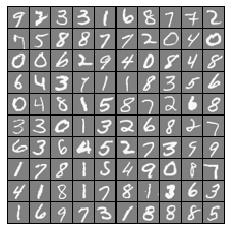

(<matplotlib.image.AxesImage at 0x1fc9544f1c8>,
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        ...,
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1.,  0.,  0., ...,  0.,  0., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]))

In [12]:
print('Visualizing data....')

#Randomly select 100 data points to display
#rand_indices = np.random.permutation(m)
#sel = X[rand_indices[0:100], :]
rand_indices = np.random.choice(m, 100)
sel = X[rand_indices, :]

displayData(sel)

<p>This is the same dataset that we used in the previous exercise. There are 5000 training examples in ex4data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a ﬂoating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.</p>

$$X = \begin{bmatrix} (x^1)^T \\ (x^2)^T \\ ... \\ (x^m)^T \end{bmatrix}$$

<p>The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.</p>

### 1.2 Model Representation

<p>Our neural network is shown in Figure 2. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data will be loaded into the variables X and y.</p>

<p>You have been provided with a set of network parameters ($\theta(1), \theta(2)$) already trained by us. These are stored in ex4weights.mat and will be loaded into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).</p>

<img src="Figure 2.png">

In [13]:
#Loading Parameters
print('Loading saved neural network parameters...')

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('ex4weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

print(Theta1.shape, Theta2.shape)

Loading saved neural network parameters...
(25, 401) (10, 26)


### 1.3 Feedforward and Cost Function

<p>Now you will implement the cost function and gradient for the neural network. First, complete the code in nnCostFunction() to return the cost.</p>

<p>Recall that the cost function for the neural network (without regularization) is</p>

$$J(θ) = -\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K [y_k^{(i)}log(h_\theta(x^{(i)})) + (1-y_k^{(i)})log(1-h_\theta(x^{(i)}))_k]$$

<p>where $h_\theta(x^{(i)})$ is computed as shown in the Figure 2 and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the k-th output unit. Also, recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that</p>
$$y = \begin{bmatrix} 1 \\ 0 \\ 0 \\... \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 1 \\ 0 \\... \\ 0 \end{bmatrix}, ... or \begin{bmatrix} 0 \\ 0 \\ 0 \\... \\ 1 \end{bmatrix}$$

<p>For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5$ = 1, and the other elements equal to 0.</p>

<p>You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example i and sum the cost over all examples. <b>Your code should also work for a dataset of any size, with any number of labels</b> (you can assume that there are always at least K ≥ 3 labels).</p>

In [14]:
print('Feedforward using neural network: ')

#Regularization parameter set to 0
lambda_ = 0

nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)

print('Cost at parameters loaded by ex4weights is:', J, '\n(this value should be 0.287629)')

Feedforward using neural network: 
Cost at parameters loaded by ex4weights is: (0.2876291651613189, array([ 6.18712766e-05,  9.38798109e-05, -1.92593606e-04, ...,
       -9.84907927e-04,  1.27957448e-03,  1.35707295e-03])) 
(this value should be 0.287629)


### 1.4 Regularized Cost Function

<p>The cost function for neural networks with regularization is given by</p>

$$J(θ) = -\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K [y_k^{(i)}log(h_\theta(x^{(i)})) + (1-y_k^{(i)})log(1-h_\theta(x^{(i)}))_k] + \frac{\lambda}{2m} [\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta^{(1)}_{j,k})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\theta^{(2)}_{j,k})^2] $$

<p>You can assume that the neural network will only have 3 layers – an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\theta^{(1)}$ and $\theta^{(2)}$ for clarity, do note that <b>your code should in general work with $\theta^{(1)}$ and $\theta^{(2)}$ of any size.</b></p>

<p>Note that you should not be regularizing the terms that correspond to the bias. For the matrices Theta1 and Theta2, this corresponds to the ﬁrst column of each matrix. You should now add regularization to your cost function. Notice that you can ﬁrst compute the unregularized cost function J using your existing nnCostFunction() and then later add the cost for the regularization terms.</p>

<p>Once you are done, call your nnCostFunction() using the loaded set of parameters for Theta1 and Theta2, and λ = 1. You should see that the cost is about 0.383770.</p>

In [15]:
print('Checking cost function with regularization: ')

#Regularization parameter (we set this to 1 here)
lambda_ = 1

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)

print('Cost at parameters loaded by ex4weights is:', J, '\n(this value should be 0.383770)')

Checking cost function with regularization: 
Cost at parameters loaded by ex4weights is: (0.38376985909092365, array([ 6.18712766e-05,  9.38798109e-05, -1.92593606e-04, ...,
       -6.47826038e-04,  8.57546470e-04,  9.30689893e-04])) 
(this value should be 0.383770)


## 2. Back propagation

<p>In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to complete the nnCostFunction() so that it returns an appropriate value for grad. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as fmin_cg.</p>

<p>You will ﬁrst implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have veriﬁed that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.</p>

### 2.1 Sigmoid Gradient

<p>To help you get started with this part of the exercise, you will ﬁrst implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as </p>

$$g'(z) = \frac{d}{dz} g(z) = g(z)(1-g(z))$$

<p>where</p>

$$sigmoid(z) = g(z) = \frac{1}{1+e^{-z}}$$

<p>When you are done, try testing a few values by calling sigmoidGradient(z). For large values (both positive and negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.</p>

In [16]:
print('Evaluating sigmoid gradient..')

g = sigmoidGradient([-1, -0.5, 0, 0.5, 1])
print('Sigmoid gradient evaluated at [-1, -0.5, 0, 0.5, 1]:\n', g)

Evaluating sigmoid gradient..
Sigmoid gradient evaluated at [-1, -0.5, 0, 0.5, 1]:
 [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


### 2.2 Random Initialization

<p>When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One eﬀective strategy for random initialization is to randomly select values for $\theta^{(l)}$ uniformly in the range $[−\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init}$ = 0.12. This range of values ensures that the parameters are kept small and makes the learning more eﬃcient.</p>

In [17]:
print('Initializing NN parameters: ')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

#Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.reshape(initial_Theta1.size, order='F'), 
                                    initial_Theta2.reshape(initial_Theta2.size, order='F')))

Initializing NN parameters: 


### 2.3 Backpropagation

<img src = "Figure 3.png">

<p>Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)},y^{(t)})$, we will ﬁrst run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node j in layer l, we would like to compute an “error term” $\delta^{(l)}_j$ that measures how much that node was “responsible” for any errors in our output.</p>

<p>For an output node, we can directly measure the diﬀerence between the network’s activation and the true target value, and use that to deﬁne $\delta^{(3)}_j$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta^{(l)}_j$ based on a weighted average of the error terms of the nodes in layer (l + 1).</p>

<p>In detail, here is the backpropagation algorithm (also depicted in Figure 3). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for t = 1:m and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)},y^{(t)})$. Step 5 will divide the accumulated gradients by m to obtain the gradients for the neural network cost function.</p>

<ol>
    <li>Set the input layer’s values $(a^{(1)})$ to the t-th training example $x^{(t)}$. Perform a feedforward pass (Figure 2), computing the activations $(z^{(2)},a^{(2)},z^{(3)},a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$ and $a{(2)}$ also include the bias unit.</li>
    <li> For each output unit k in layer 3 (the output layer), set
        $$\delta^{(3)}_k = (a^{(3)}_k - y_k)$$
        where $y_k ∈ {0,1}$ indicates whether the current training example belongs to class k $(y_k = 1)$, or if it belongs to a diﬀerent class $(y_k = 0)$. You may ﬁnd logical arrays helpful for this task (explained in the previous programming exercise).</li>
    <li> For the hidden layer l = 2, set 
        $$\delta^{(2)} = (\theta^{(2)})^T \delta^{(3)} .* g'(z^{(2)}$$ </li>
    <li> Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta^{(2)}_0$.
        $$\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T$$ </li>
    <li>Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
        $$\frac{\partial}{\partial\theta^{(l)}_{ij}} J(\theta) = D^{(l)}_{ij} = \frac{1}{m} \Delta^{(l)}_{ij}$$ </li>
</ol>

<p>After you have implemented the backpropagation algorithm, the script ex4.m will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your conﬁdence that your code is computing the gradients correctly.</p>

### 2.4 Gradient checking

<p>In your neural network, you are minimizing the cost function $J(\theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\theta^{(1)}, \theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\theta)$ instead and use the following gradient checking procedure.</p>

<p>Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.</p>

<p> Let </p>
$$\theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ ... \\ \epsilon \\ ... \\ 0 \end{bmatrix} , \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ ... \\ \epsilon \\ 0 \end{bmatrix}$$

<p>So, $\theta^{(i+)}$ is the same as $\theta$, except its i-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the i-th element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each i, that:</p>
$$f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}$$

<p>The degree to which these two values should approximate each other will depend on the details of J. But assuming $\epsilon = 10^{-4}$, you’ll usually ﬁnd that the left- and right-hand sides of the above will agree to at least 4 signiﬁcant digits (and often many more).</p>

<p>We have implemented the function to compute the numerical gradient for you in computeNumericalGradient(). While you are not required to modify the ﬁle, we highly encourage you to take a look at the code to understand how it works.</p>

<p>In the next step, it will run the provided function checkNNGradients() which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct, you should see a relative diﬀerence that is less than 1e-9.</p>

In [18]:
print('Checking Backpropagation...')

#Check gradients by running checkNNGradients
checkNNGradients()

Checking Backpropagation...
Numerical Gradient       Analytical Gradient
0.0377805465623382       0.03778054659834626
0.0668531912406678       0.06685319129658132
0.03454038772332524      0.03454038776263527
-0.029647301609259102    -0.029647301630587385
-0.06645480413958182     -0.06645480419400639
0.0004766875250084013    0.00047668753345895865
0.0009134180034564565    0.0009134180078127476
0.0005100516409228817    0.0005100516434187682
-0.00036263437142025623  -0.0003626343726487506
-0.0008998974498908296   -0.0008998974493869074
0.0007755676412202206    0.000775567636929346
0.0012982864339150524    0.001298286432799179
0.0006265634855395774    0.0006265634895424362
-0.0006214453929231922   -0.0006214453964076522
-0.0012954651662511196   -0.0012954651703755387
0.00036139442993743387   0.0003613944317203012
0.0004895163030482763    0.0004895162988246889
0.00016701575678013114   0.00016701575292636452
-0.0003089023925539891   -0.00030890238865163887
-0.0004999881841882825   -0.0004999

### 2.5 Regularized Neural Networks

<p>After you have successfully implemeted the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term <i>after</i> computing the gradients using backpropagation.</p>

<p>Speciﬁcally, after you have computed $\Delta^{(l)}_{ij}$ using backpropagation, you should add regularization using</p>

<ul>
<li>$\frac{\partial}{\partial\theta^{(l)}_{ij}} J(\theta) = D^{(l)}_{ij} = \frac{1}{m} \Delta^{(l)}_{ij}$, for j = 0</li>
<li>$\frac{\partial}{\partial\theta^{(l)}_{ij}} J(\theta) = D^{(l)}_{ij} = \frac{1}{m} \Delta^{(l)}_{ij} + \frac{\lambda}{m}\theta^{(l)}_{ij}$, for j >= 1</li>
</ul>

<p>Note that you should not be regularizing the ﬁrst column of $\theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\theta^{(l)}_{ij}$, i is indexed starting from 1, and j is indexed starting from $\theta$.</p>

<p>Now modify your code that computes <b>grad</b> in nnCostFunction() to account for regularization. After you are done, the script will proceed to run gradient checking on your implementation. If your code is correct, you should expect to see a relative diﬀerence that is less than 1e-9. </p>

In [19]:
print('Checking Backpropagation with Regularization...')

#Check gradients by running checkNNGradients
lambda_ = 3
checkNNGradients(lambda_)

Checking Backpropagation with Regularization...
Numerical Gradient       Analytical Gradient
0.0377805465623382       0.03778054659834626
0.0668531912406678       0.06685319129658132
0.03454038772332524      0.03454038776263527
-0.029647301609259102    -0.029647301630587385
-0.06645480413958182     -0.06645480419400639
0.055034533135156494     0.055034533142999865
-0.01585151188976397     -0.015851511884122805
-0.03213121501310923     -0.03213121500994342
0.05907380697056652      0.05907380696904347
-0.04595913225546866     -0.04595913225568748
0.009242768124195777     0.009242768120521378
0.04071748235912054      0.040717482355926524
-0.05937284890844552     -0.059372848903499774
0.03839582501719008      0.03839582501301936
0.007697167414555395     0.007697167409401601
-0.045046755290378826    -0.04504675528675539
0.05985101109828861      0.05985101109622759
-0.032027359324615645    -0.03202735932709973
-0.017583101392659728    -0.017583101388555556
0.054276726859647795     0.05427672

In [21]:
debug_J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
print('Cost at (fixed) debugging parameters, with lambda = {}, is {}'.format(lambda_, debug_J))
print('For lambda = 3, the value should be about 0.576051')

Cost at (fixed) debugging parameters, with lambda = 3, is 0.5760512469501332
For lambda = 3, the value should be about 0.576051


### 2.6 Learning Parameters

<p>After you have successfully implemented the neural network cost function and gradient computation, the next step of the script will use <b>optimizer</b> to learn a good set parameters.</p>

<p>After the training completes, the script will proceed to report the training accuracy of your classiﬁer by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set MaxIter to 400) and also vary the regularization parameter λ. With the right learning settings, it is possible to get the neural network to perfectly ﬁt the training set.</p>

In [30]:
import scipy.optimize as opt

print('Training Neural Network...')

#After you have completed the assignment, change the MaxIter to a larger value to see how more training helps
options = {'maxiter':50}

#You should also try different values of lambda
lambda_ = 1

#Create "short hand" for the cost function to be minimized
def costFunc(p):
    return nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)

#Now, costFunction is a function that takes in only one argument (the neural network parameters)
res = opt.minimize(costFunc,
                  initial_nn_params,
                  jac=True,
                  method='CG',
                  options=options)

#cost = res.fun
nn_params = res.x

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], 
                    (hidden_layer_size, input_layer_size + 1), order='F')

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, hidden_layer_size + 1), order='F')

Training Neural Network...


## 3. Visualizing the hidden layer

<p>One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to ﬁnd an input x that will cause it to activate (that is, to have an activation value ($a^{(l)}_i$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.</p>

<p>Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it. The next step does this by using the displayData() function and it will show you an image (similar to Figure 4) with 25 units, each corresponding to one hidden unit in the network. In your trained network, you should ﬁnd that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.</p>

<img src='Figure 4.png'>

Visualizing Neural Network...


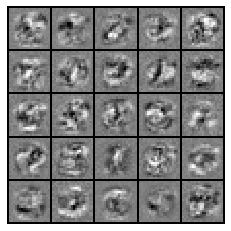

(<matplotlib.image.AxesImage at 0x1fc96bf9ac8>,
 array([[-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -0.03728914,  0.01233713, ..., -0.042591  ,
         -0.06668102, -1.        ],
        [-1.        , -0.05601054,  0.04183544, ...,  0.09997568,
          0.06184679, -1.        ],
        ...,
        [-1.        , -0.05302179,  0.05174791, ..., -0.01407212,
          0.04835385, -1.        ],
        [-1.        ,  0.04397782,  0.04726203, ..., -0.0781883 ,
         -0.03268558, -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]]))

In [31]:
print('Visualizing Neural Network...')

displayData(Theta1[:,1:])

In [33]:
pred = predict(Theta1, Theta2, X)
print('Training set accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training set accuracy: 96.50%
